<a href="https://colab.research.google.com/github/VedantWani/Swarm-Intelligence/blob/master/Whale_Optimization_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
class Particle:
    pass

In [4]:
class WOA:
    def __init__(self,a, a_step, b, population, fitness_eval_func,n_dims, dim_limits):
        '''
            input:
                    
                    population: total number of solutions to generate
                    fintess_eval_func: fitness evaluation function
                    n_dims: number of dimensions for the solution
                    dim_limit (dictionary): keys being the index for which the limit i.e value of the key is applicable
                    

            ref:
              Seyedali Mirjalili, Andrew Lewis,
              The Whale Optimization Algorithm,
              Advances in Engineering Software,
              Volume 95,
              2016,
              Pages 51-67,
              ISSN 0965-9978,
              https://doi.org/10.1016/j.advengsoft.2016.01.008.
              (https://www.sciencedirect.com/science/article/pii/S0965997816300163)
              Abstract: This paper proposes a novel nature-inspired meta-heuristic optimization algorithm, called Whale Optimization Algorithm (WOA), which mimics the social behavior of humpback whales. The algorithm is inspired by the bubble-net hunting strategy. WOA is tested with 29 mathematical optimization problems and 6 structural design problems. Optimization results prove that the WOA algorithm is very competitive compared to the state-of-art meta-heuristic algorithms as well as conventional methods. The source codes of the WOA algorithm are publicly available at http://www.alimirjalili.com/WOA.html
              Keywords: Optimization; Benchmark; Constrained optimization; Particle swarm optimization; Algorithm; Heuristic algorithm; Genetic algorithm; Structural optimization
        '''
        
        self._a = a
        self._a_step = a_step
        self._b = b
        self.population = population
        self.fitness_eval_func = fitness_eval_func
        self.n_dims = n_dims
        self.dim_limits = dim_limits
        self.best_solutions = []
        self.Swarm = []
        
    def _initialize_population(self):
        '''Initialize the whale population'''
        for solution in range(self.population):
            start = 0
            whale = Particle()
            whale.position = np.array([])
            for end in self.dim_limits:
                vec = np.random.uniform(*self.dim_limits[end], (end-start))
                whale.position = np.concatenate((whale.position, vec))
                start = end
            
            whale.fitness = self.fitness_eval_func(whale.position)
            
            self.Swarm.append(whale) 
            
        #sort according to fitness
        self._sort_fitness()
        
        #add best solution i.e keep track best solution is at top
        self.best_solutions.append(self.Swarm[0])
       

  
    def optimize(self):
       
        # prey = best solution
        prey = self.Swarm[0]
        #print(f'Best solution {prey.position}')
        for whale in self.Swarm[1:]:
            if np.random.uniform() > 0.5:
                A = self._compute_A()
                norm_A = np.linalg.norm(A)
                
                if norm_A < 1.0:
                    whale.position = self._encircle_prey(whale_pos = whale.position, prey_pos = prey.position, A = A)
                else:
                    random_prey = self.Swarm[np.random.randint(1, self.population)]
                    whale.position = self._search_prey(whale_pos = whale.position, random_prey_pos = random_prey.position, A = A)
            else:
                whale.position = self._attack(whale_pos = whale.position, prey_pos = prey.position)
            
            #constraint the whales limits
            whale.position = self._constraint_solutions(whale.position)
            
            #calculate fitness
            whale.fitness = self.fitness_eval_func(whale.position)
        
        self._a -= self._a_step
        
        #sort according to fitness
        self._sort_fitness()
        
        #add best solution i.e keep track best solution is at top
        self.best_solutions.append(self.Swarm[0])
        
    
    def _constraint_solutions(self, position):
        start = 0
        for end in self.dim_limits:
            position[start:end] = np.maximum(position[start:end], self.dim_limits[end][0]) #minimum limit
            position[start:end] = np.minimum(position[start:end], self.dim_limits[end][1]) # maximum limit
            
            start = end
            
        return position
    
    def _encircle_prey(self, whale_pos, prey_pos, A):
        '''
            Exploitation phase
            Update position according to the prey i.e Shrinking encircling Mechanism
            
            Xi_new = X* - (A . D)
            
            where
                X* is Best solution
                
        '''
        D = self._compute_D(prey_pos = prey_pos, whale_pos = whale_pos)
        return prey_pos - (A * D)
    
    def _search_prey(self,whale_pos,random_prey_pos, A):
        '''
            Exploration phase
            return new position
            
            Xi_new = X_rand - (A . D)
            
            where
                X_rand is random search agent 
        
        '''
        D = self._search_D(random_prey_pos = random_prey_pos, whale_pos = whale_pos)
        return random_prey_pos - (A * D)
    
    def _attack(self,whale_pos, prey_pos):
        '''
            Exploitation phase
            Spiral updating phase
            
            prey = Best search Agent
            
            D = |X* - Xi|
            L = random number betwwen -1.0 to 1.0
            Xi_new = (D . (exp^(b*L) . cos(2*pi*L))) + X*
        '''
        D = np.linalg.norm(prey_pos - whale_pos)
        L = np.random.uniform(-1.0, 1.0, size=self.n_dims)
        
        return (D * (np.exp(self._b * L) * np.cos(2.0 * np.pi * L))) + prey_pos
    
    def _sort_fitness(self):
        
        self.Swarm.sort(key = lambda prey:prey.fitness, reverse = False)
        
    
    def _get_random_vector(self,dims):
        return np.random.uniform(size = dims)
    
    def _compute_A(self):
        '''
            A_vec = (2.0 * (a . r_vec)) - a
            where:
                r_vec is random vector between 0,1
        '''
        r_vec = self._get_random_vector(dims = self.n_dims)
        return (2.0*(self._a * r_vec)) - self._a
    
    def _compute_C(self):
        '''
            C_vec = 2 . r_vec
            
            where:
                 r_vec is random vector between 0,1
        '''
        r_vec = self._get_random_vector(dims = self.n_dims)
        return 2.0 * r_vec
    
    def _compute_D(self, prey_pos, whale_pos):
        '''
            prey: if best_soltion ---> encircle_d 
                  if random_solution ---> search_d
            whale: that encircles the prey
            
            D = |(C_vec . X*) - Xi|
            where 
                X* is the best solution
                Xi current search agent
        '''
        C = self._compute_C()
        return np.linalg.norm((C*prey_pos) - whale_pos)
  
    def _search_D(self,random_prey_pos, whale_pos):
        '''
            D = |(C_vec . X_rand) - Xi|
            where 
                X_rand is the Random search agent
                Xi current search agent
        '''
        return self._compute_D(prey_pos = random_prey_pos, whale_pos = whale_pos)
    

In [5]:
def sphere_fitness(position):
    total = 0
  
    for i in range(len(position)):
        total+=position[i]**2
    return total

In [6]:
dim_limits = {3:(-5,5)}

In [7]:
woa = WOA(a = 2.0,b= 0.5, a_step= 2.0/100, population = 30, fitness_eval_func=sphere_fitness, n_dims=3, dim_limits= dim_limits)

In [8]:
xs = []
ys = []
zs = []

In [9]:
woa._initialize_population()
for i in range(100):
    woa.optimize()
    xt = []
    yt = []
    zt = []
    for whale in woa.Swarm:
        xt.append(whale.position[0])
        yt.append(whale.position[1])
        zt.append(whale.position[2])
    xs.append(xt)
    ys.append(yt)
    zs.append(zt)

In [10]:
woa.best_solutions[-1].fitness

3.9506934530804896e-11

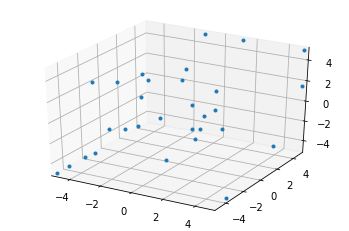

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct, = ax.plot([], [], [], "o", markersize=3)
def update(ifrm, xa, ya, za):
    #print(ifrm)
    sct.set_data(xa[ifrm], ya[ifrm])
    sct.set_3d_properties(za[ifrm])
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)
ani = animation.FuncAnimation(fig, update, frames=100, fargs=(xs,ys,zs), interval = 100)
HTML(ani.to_html5_video())